In [6]:
%matplotlib inline

from pathlib import Path
from drone_detector.tiling import *
import os, sys
import geopandas as gpd
import math

# Make data

In [2]:
tile_folder = Path('../data/hiidenportti/raw/plot_patches/')
vector_folder = Path('../data/hiidenportti/raw/vector_plots/')

outpath = Path('../data/hiidenportti/processed_unet/')

if not os.path.exists(outpath): os.makedirs(outpath)

tiles = os.listdir(tile_folder)
vectors = [f for f in os.listdir(vector_folder) if f.endswith('geojson')]
assert len(tiles) == len(vectors)

In [3]:
import rasterio as rio

In [7]:
from shapely.geometry import Polygon
def fix_multipolys(multipoly):
    temp_poly = None
    max_area = 0
    for geom in multipoly.geoms:
        area = geom.area
        if area > max_area:
            max_area = area
            temp_poly = geom
    return Polygon(temp_poly.exterior)

In [9]:
for t in tiles:
    with rio.open(tile_folder/t) as f:
        im = f.read()
        tilesize = math.floor(min(im.shape[1], im.shape[2])/8)
    if not os.path.exists(outpath/t[:-4]): os.makedirs(outpath/t[:-4])
    shp_fname = t.replace('tif', 'geojson')
    #tilesize = 500
    tiler = Tiler(outpath=outpath/t[:-4], gridsize_x=tilesize, gridsize_y=tilesize, overlap=(0,0))
    tiler.tile_raster(str(tile_folder/t))
    tiler.tile_vector(vector_folder/shp_fname)
    for patch in (f'{tiler.vector_path}/{f}' for f in os.listdir(tiler.vector_path) if f.endswith('geojson')):
        gdf = gpd.read_file(patch)
        #gdf['geometry'] = gdf.geometry.buffer(0.05)
        gdf['geometry'] = gdf.apply(lambda row: fix_multipolys(row.geometry) if row.geometry.type=='MultiPolygon'
                                    else Polygon(row.geometry.exterior), axis=1)
        gdf.to_file(patch, driver='GeoJSON')
    tiler.tile_and_rasterize_vector('groundwood')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

# Train model

In [10]:
from fastai.vision.all import *
from drone_detector.visualizations import *
from drone_detector.data import *

In [11]:
fnames = [Path(f'{outpath}/{tile}/raster_tiles/{f}') 
          for tile in [til for til in os.listdir(outpath) if os.path.isdir(outpath/til)]
          for f in os.listdir(outpath/tile/'rasterized_vector_tiles/')]

deadwood = SegmentationDataLoaders.from_label_func('../data/analysis_data', bs=16,
                                                   codes=['Standing', 'Fallen'],
                                                   fnames=fnames,
                                                   label_func=partial(label_from_different_folder, 
                                                                      original_folder='raster_tiles',
                                                                      new_folder='rasterized_vector_tiles'),
                                                   item_tfms=[Resize(256)],
                                                   batch_tfms= [
                                                       *aug_transforms(size=224),
                                                       Normalize.from_stats(*imagenet_stats)
                                                   ])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggere

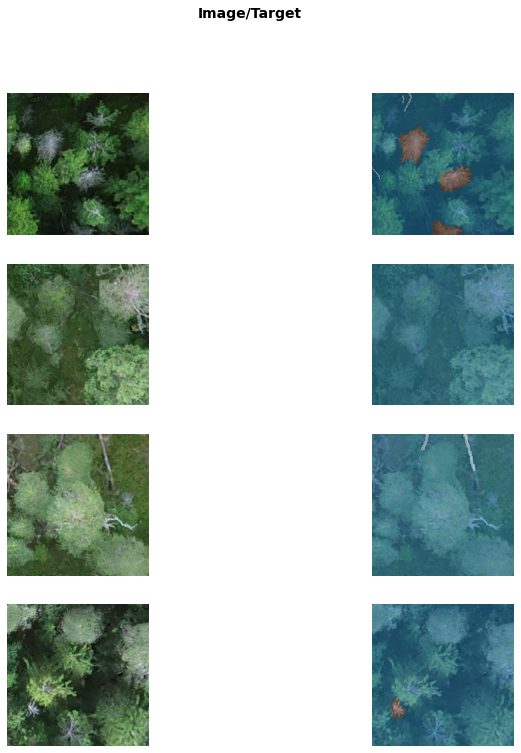

In [13]:
deadwood.show_batch(max_n=8)

In [14]:
from drone_detector.losses import LovaszSoftmaxLossFlat, FocalDice
from drone_detector.metrics import JaccardCoeffMulti

learn = unet_learner(deadwood, resnet101, pretrained=True, n_in=3, n_out=3,
                     metrics=[DiceMulti(), JaccardCoeffMulti()], loss_func=LovaszSoftmaxLossFlat()
                    ).to_fp16()

/opt/conda/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=5.754399353463668e-06)

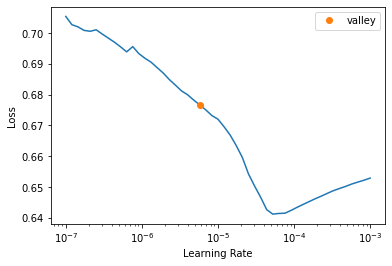

In [15]:
learn.lr_find()

epoch,train_loss,valid_loss,dice_multi,jaccard_coeff_multi,time
0,0.505960,0.458136,0.587760,0.240920,01:51
1,0.422219,0.407172,0.639892,0.304439,01:50


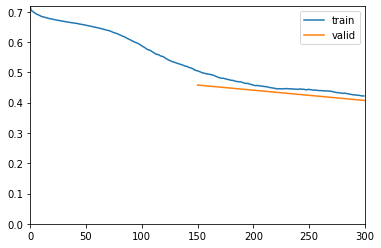

epoch,train_loss,valid_loss,dice_multi,jaccard_coeff_multi,time
0,0.394016,0.388474,0.711658,0.402833,01:53
1,0.387232,0.392294,0.714578,0.404427,01:53
2,0.380179,0.385818,0.698297,0.382339,01:53
3,0.379585,0.383921,0.722329,0.415978,01:53
4,0.367072,0.377678,0.733082,0.433019,01:53
5,0.358365,0.360301,0.767770,0.488357,01:53
6,0.349743,0.363733,0.763733,0.480986,01:52
7,0.352755,0.356171,0.777326,0.504547,01:53
8,0.345522,0.358031,0.772503,0.496076,01:53
9,0.338219,0.356420,0.773462,0.497814,01:53


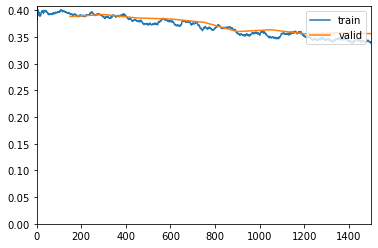

In [16]:
from fastai.callback.progress import ShowGraphCallback
learn.fine_tune(10, freeze_epochs=2, base_lr=1e-5, cbs=ShowGraphCallback)

In [17]:
learn.to_fp32()

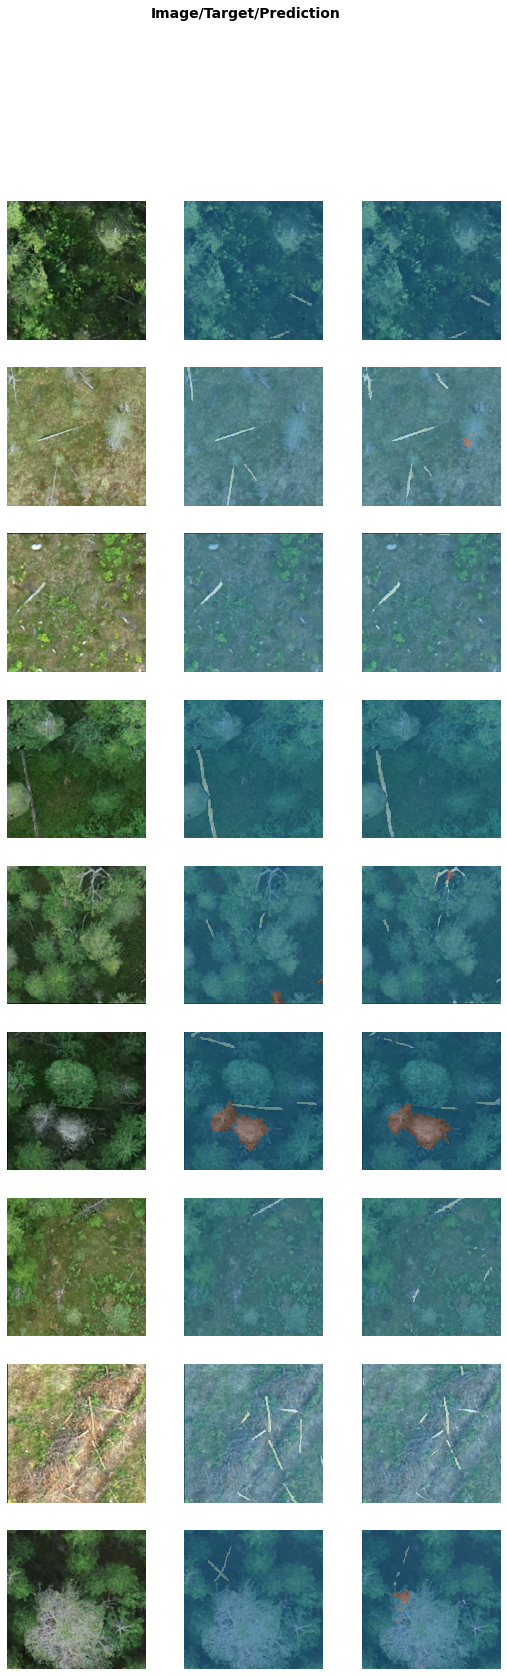

In [22]:
learn.show_results()

In [24]:
learn.path = Path('hiidenportti_models/')

In [25]:
learn.export('unet_hiidenportti_lovasz.pkl')

# Test with holdout

In [26]:
from drone_detector.predict import predict_segmentation

In [27]:
test_rasters = [f'../data/hiidenportti/raw/test_plot_patches/{f}' 
                for f in os.listdir('../data/hiidenportti/raw/test_plot_patches') if f.endswith('tif')]

In [75]:
for t in test_rasters:
    outfile_name = f'../data/hiidenportti/unet/{t.split("/")[-1]}'
    predict_segmentation('hiidenportti_models/unet_hiidenportti_lovasz.pkl', t, outfile_name, 
                         processing_dir='temp', use_tta=False,
                         tile_size=230, tile_overlap=115)

Reading and tiling ../data/hiidenportti/raw/test_plot_patches/1053_Hiidenportti_Chunk9_orto.tif to 230x230 tiles with overlap of 115px


0it [00:00, ?it/s]

Starting prediction


/opt/conda/lib/python3.8/site-packages/fastai/metrics.py:366: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)
/scratch/mayrajan/drone_detector/drone_detector/metrics.py:104: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_jaccard_scores)


Rasterizing predictions


0it [00:00, ?it/s]

Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/1022_Hiidenportti_Chunk1_orto.tif to 230x230 tiles with overlap of 115px


0it [00:00, ?it/s]

Starting prediction


/opt/conda/lib/python3.8/site-packages/fastai/metrics.py:366: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)
/scratch/mayrajan/drone_detector/drone_detector/metrics.py:104: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_jaccard_scores)


Rasterizing predictions


0it [00:00, ?it/s]

Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/1083_Hiidenportti_Chunk6_orto.tif to 230x230 tiles with overlap of 115px


0it [00:00, ?it/s]

Starting prediction


/opt/conda/lib/python3.8/site-packages/fastai/metrics.py:366: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)
/scratch/mayrajan/drone_detector/drone_detector/metrics.py:104: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_jaccard_scores)


Rasterizing predictions


0it [00:00, ?it/s]

Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/1035_Hiidenportti_Chunk5_orto.tif to 230x230 tiles with overlap of 115px


0it [00:00, ?it/s]

Starting prediction


/opt/conda/lib/python3.8/site-packages/fastai/metrics.py:366: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)
/scratch/mayrajan/drone_detector/drone_detector/metrics.py:104: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_jaccard_scores)


Rasterizing predictions


0it [00:00, ?it/s]

Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/1040_Hiidenportti_Chunk8_orto.tif to 230x230 tiles with overlap of 115px


0it [00:00, ?it/s]

Starting prediction


/opt/conda/lib/python3.8/site-packages/fastai/metrics.py:366: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)
/scratch/mayrajan/drone_detector/drone_detector/metrics.py:104: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_jaccard_scores)


Rasterizing predictions


0it [00:00, ?it/s]

Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/1025_Hiidenportti_Chunk5_orto.tif to 230x230 tiles with overlap of 115px


0it [00:00, ?it/s]

Starting prediction


/opt/conda/lib/python3.8/site-packages/fastai/metrics.py:366: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)
/scratch/mayrajan/drone_detector/drone_detector/metrics.py:104: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_jaccard_scores)


Rasterizing predictions


0it [00:00, ?it/s]

Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/114_Hiidenportti_Chunk5_orto.tif to 230x230 tiles with overlap of 115px


0it [00:00, ?it/s]

Starting prediction


/opt/conda/lib/python3.8/site-packages/fastai/metrics.py:366: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)
/scratch/mayrajan/drone_detector/drone_detector/metrics.py:104: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_jaccard_scores)


Rasterizing predictions


0it [00:00, ?it/s]

Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/1092_Hiidenportti_Chunk6_orto.tif to 230x230 tiles with overlap of 115px


0it [00:00, ?it/s]

Starting prediction


/opt/conda/lib/python3.8/site-packages/fastai/metrics.py:366: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)
/scratch/mayrajan/drone_detector/drone_detector/metrics.py:104: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_jaccard_scores)


Rasterizing predictions


0it [00:00, ?it/s]

Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/1033_Hiidenportti_Chunk3_orto.tif to 230x230 tiles with overlap of 115px


0it [00:00, ?it/s]

Starting prediction


/opt/conda/lib/python3.8/site-packages/fastai/metrics.py:366: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)
/scratch/mayrajan/drone_detector/drone_detector/metrics.py:104: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_jaccard_scores)


Rasterizing predictions


0it [00:00, ?it/s]

Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/23_Hiidenportti_Chunk6_orto.tif to 230x230 tiles with overlap of 115px


0it [00:00, ?it/s]

Starting prediction


/opt/conda/lib/python3.8/site-packages/fastai/metrics.py:366: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)
/scratch/mayrajan/drone_detector/drone_detector/metrics.py:104: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_jaccard_scores)


Rasterizing predictions


0it [00:00, ?it/s]

Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files


In [80]:
from osgeo import gdal, ogr

In [81]:
raster_path = '../data/hiidenportti/raw/test_plot_patches/'
vector_path = '../data/hiidenportti/raw/buffered_test_vector_plots/'
rasterized_vector_path = '../data/hiidenportti/unet/truths/'
raster_files = sorted([f for f in os.listdir(raster_path)])
vector_files = sorted([f for f in os.listdir(vector_path)])

In [82]:
from tqdm import tqdm
column = 'groundwood'
for r, v in tqdm(zip(raster_files, vector_files)):
    source_raster = gdal.Open(f'{raster_path}/{r}', gdal.GA_ReadOnly)
    source_vector = ogr.Open(f'{vector_path}/{v}')
    source_vector_layer = source_vector.GetLayer()

    output_raster = gdal.GetDriverByName('gtiff').Create(f'{rasterized_vector_path}/{r}',
                                                         source_raster.RasterXSize,
                                                         source_raster.RasterYSize,
                                                         1,
                                                         gdal.GDT_Int16)
    output_raster.SetProjection(source_raster.GetProjectionRef())
    output_raster.SetGeoTransform(source_raster.GetGeoTransform())
    band = output_raster.GetRasterBand(1)
    #band.SetNoDataValue(0)
    gdal.RasterizeLayer(output_raster, [1], source_vector_layer, options=[f'ATTRIBUTE={column}'])

    band = None
    source_vector = None
    source_raster = None
    output_raster = None    

10it [00:00, 21.13it/s]


In [83]:
import rasterio as rio
import rasterio.mask as rio_mask
from shapely.geometry import box

result_path = '../data/hiidenportti/unet/preds/'

for f, pred, truth in zip(sorted(os.listdir(vector_path)), sorted(os.listdir(result_path)), sorted(os.listdir(rasterized_vector_path))):
    temp_gdf = gpd.read_file(f'{vector_path}/{f}')
    
    shapes = [box(*temp_gdf.total_bounds)]
    
    with rio.open(f'{result_path}/{pred}') as src:
        out_im, out_tfm = rio_mask.mask(src, shapes, crop=True)
        out_meta = src.meta

    out_meta.update({"driver": "GTiff",
                     "height": out_im.shape[1],
                     "width": out_im.shape[2],
                     "transform": out_tfm})
    
    
    with rio.open(f'{result_path}/{pred}', "w", **out_meta) as dest:
        dest.write(out_im)
        
    with rio.open(f'{rasterized_vector_path}/{truth}') as src:
        out_im, out_tfm = rio_mask.mask(src, shapes, crop=True)
        out_meta = src.meta

    out_meta.update({"driver": "GTiff",
                     "height": out_im.shape[1],
                     "width": out_im.shape[2],
                     "transform": out_tfm})
    
    
    with rio.open(f'{rasterized_vector_path}/{truth}', "w", **out_meta) as dest:
        dest.write(out_im)

In [84]:
import matplotlib.pyplot as plt
import rasterio.plot as rioplot

<AxesSubplot:>

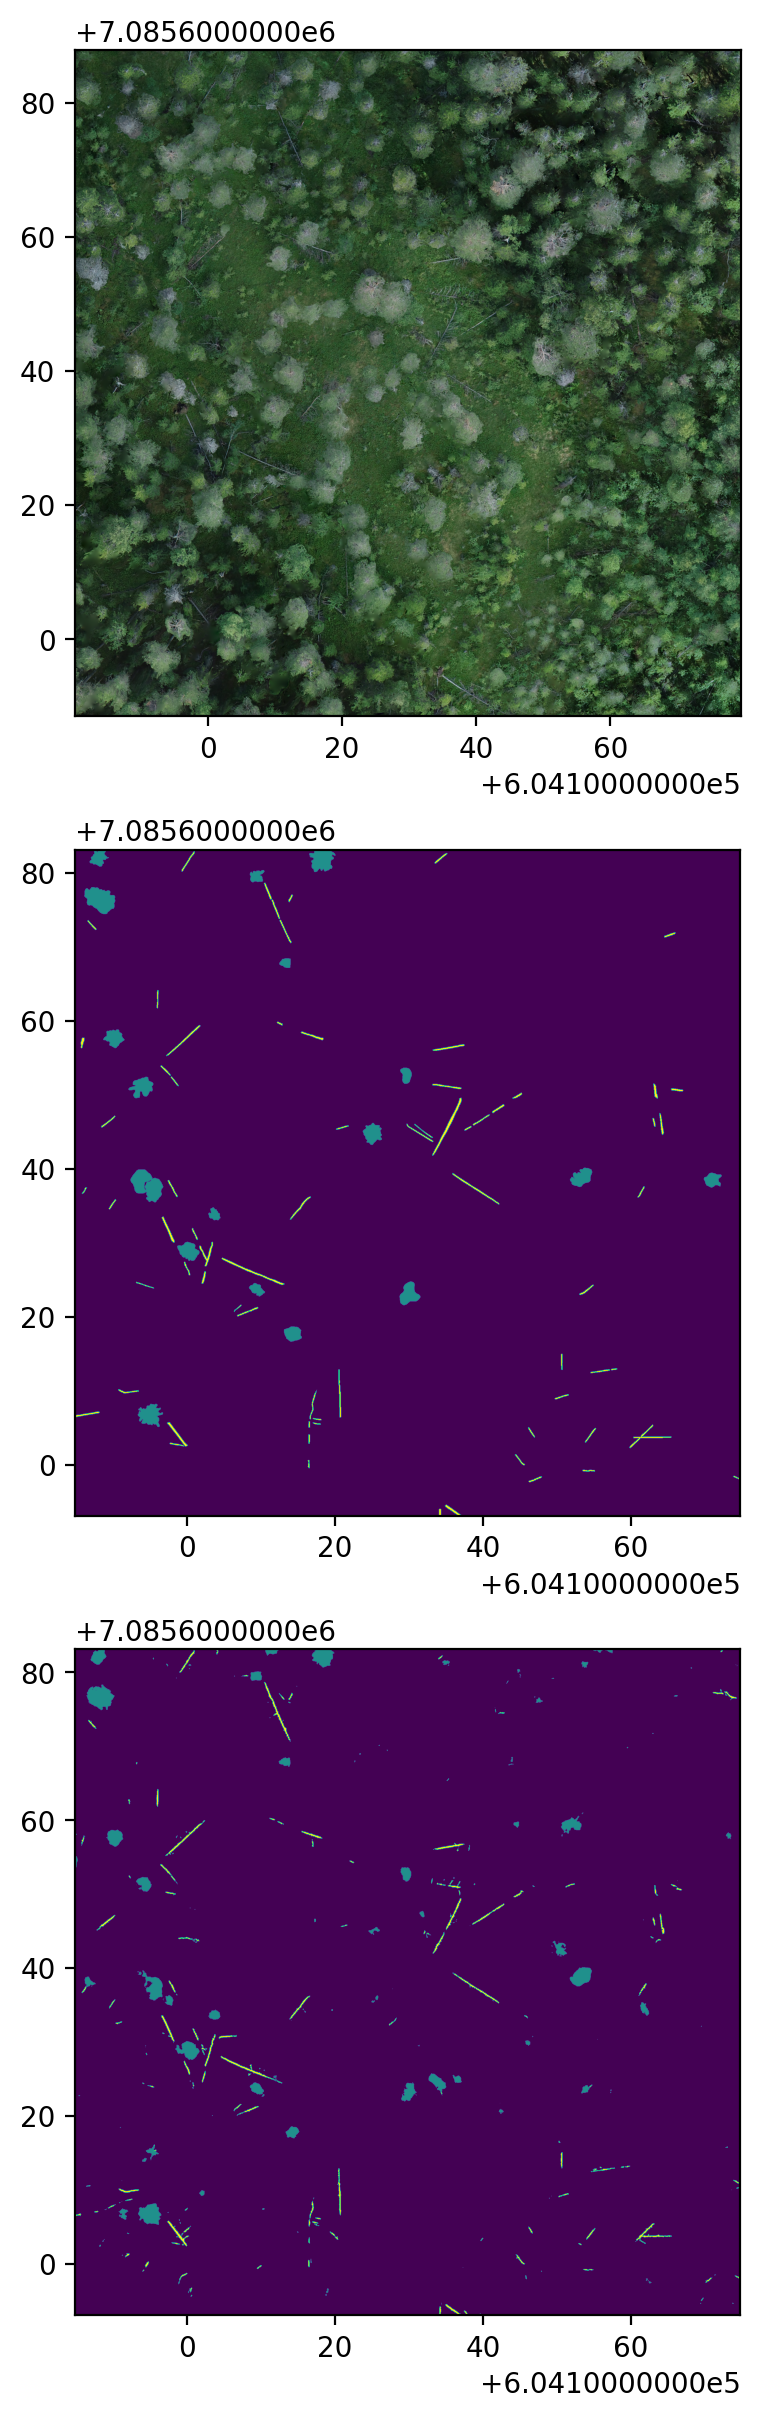

In [86]:
fig, axs = plt.subplots(3,1, figsize=(7,15), dpi=200)

ix = random.randint(0,9)
truths = sorted(os.listdir(rasterized_vector_path))
preds = sorted(os.listdir(result_path))

im = rio.open(f'{raster_path}/{truths[ix]}')
rioplot.show(im, ax=axs[0])

truth = rio.open(f'{rasterized_vector_path}/{truths[ix]}')
rioplot.show(truth, ax=axs[1], vmin=0, vmax=2)

pred = rio.open(f'{result_path}/{truths[ix]}')
rioplot.show(pred, ax=axs[2], vmin=0, vmax=2)

In [87]:
def binary_mask_iou(pred, truth, label=1):
    p = np.where(pred == label, 1, 0).ravel()
    t = np.where(truth == label, 1, 0).ravel()
    inter = (p*t).sum()
    union = (p+t).sum()
    #if t.sum() == 0: return 'No ground truth'
    #elif p.sum() == 0: return 'No predicted class'
    return inter/(union-inter) #if union > 0 else None

In [88]:
truth_vals = truth.read()
pred_vals = pred.read()
standing_iou = binary_mask_iou(truth_vals, pred_vals, 1)
standing_iou

0.5008523453703441

In [89]:
fallen_iou = binary_mask_iou(truth_vals, pred_vals, 2)
fallen_iou

0.5181698707173202

In [90]:
(standing_iou + fallen_iou) / 2

0.5095111080438322

In [91]:
np.where(pred==0, 1, 0).ravel().shape

(1,)

In [92]:
np.where(truth==0, 1, 0).ravel().shape

(1,)

In [93]:
bg_preds = np.array([])
bg_truths = np.array([])
standing_preds = np.array([])
standing_truths = np.array([])
fallen_preds = np.array([])
fallen_truths = np.array([])


for t, p in list(zip(truths, preds)):
    truth = rio.open(f'{rasterized_vector_path}/{t}').read()
    pred = rio.open(f'{result_path}/{p}').read()
    bg_preds = np.append(bg_preds, np.where(pred==0, 1, 0).ravel())
    bg_truths = np.append(bg_truths, np.where(truth==0, 1, 0).ravel())
    standing_preds = np.append(standing_preds, np.where(pred==1, 1, 0).ravel())
    standing_truths = np.append(standing_truths, np.where(truth==1, 1, 0).ravel())
    fallen_preds = np.append(fallen_preds, np.where(pred==2, 1, 0).ravel())
    fallen_truths = np.append(fallen_truths, np.where(truth==2, 1, 0).ravel())
    
bg_inter = (bg_preds*bg_truths).sum()
bg_union = (bg_preds+bg_truths).sum()
standing_inter = (standing_preds*standing_truths).sum()
standing_union = (standing_preds+standing_truths).sum()
fallen_inter = (fallen_preds*fallen_truths).sum()
fallen_union = (fallen_preds+fallen_truths).sum()

In [94]:
fallen_preds.sum() * 0.04**2

371.2592

In [95]:
fallen_truths.sum() * 0.04**2

389.0224

In [96]:
standing_preds.sum() * 0.04**2

387.35360000000003

In [97]:
standing_truths.sum() * 0.04**2

363.4192

In [98]:
bg_iou = bg_inter / (bg_union - bg_inter)
standing_iou = standing_inter / (standing_union - standing_inter)
fallen_iou = fallen_inter / (fallen_union - fallen_inter)

In [99]:
bg_iou

0.9925474608011641

In [100]:
standing_iou

0.4291897259084859

In [101]:
fallen_iou

0.5239182584377766

In [102]:
(standing_iou + fallen_iou) / 2

0.47655399217313127

In [103]:
(bg_iou + standing_iou + fallen_iou) / 3

0.6485518150491422

In [104]:
bg_dice = 2 * bg_inter / bg_union
fallen_dice = 2 * fallen_inter / fallen_union
standing_dice = 2 * standing_inter / standing_union

In [105]:
full_inter = fallen_inter + standing_inter
full_union = fallen_union + standing_union

In [106]:
2 * full_inter / full_union

0.6443733594237242

In [107]:
def accuracy_annotated(pred, truth, label):
    pred = pred.copy()
    pred[truth == 0] = 0
    p = np.where(pred == label, 1, 0).ravel()
    t = np.where(truth == label, 1, 0).ravel()
    return p.sum() / t.sum()

In [108]:
accuracy_annotated(pred_vals, truth_vals, 2)

0.6842912495963835

In [109]:
standing_masked_preds = np.array([])
standing_truths = np.array([])
fallen_masked_preds = np.array([])
fallen_truths = np.array([])


for t, p in list(zip(truths, preds)):
    truth = rio.open(f'{rasterized_vector_path}/{t}').read()
    pred = rio.open(f'{result_path}/{p}').read()
    pred[truth == 0] = 0
    standing_masked_preds = np.append(standing_masked_preds, np.where(pred==1, 1, 0).ravel())
    standing_truths = np.append(standing_truths, np.where(truth==1, 1, 0).ravel())
    fallen_masked_preds = np.append(fallen_masked_preds, np.where(pred==2, 1, 0).ravel())
    fallen_truths = np.append(fallen_truths, np.where(truth==2, 1, 0).ravel())
    
standing_ann_acc = standing_masked_preds.sum() / standing_truths.sum()
fallen_ann_acc = fallen_masked_preds.sum() / fallen_truths.sum()

In [110]:
standing_ann_acc

0.6232141835103924

In [111]:
fallen_ann_acc

0.6736187941876869